In [1]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### 查看股票数据

In [2]:
def stocks_data(symbols,dates):
    df=pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp=pd.read_csv("D:/Code/Ipynb/Pytorch/Homework/data/Stock/{}.us.txt".format(symbol),
                            index_col='Date',
                            parse_dates=True,
                            usecols=['Date','Close'],
                            na_values=['nan'])
        df_temp=df_temp.rename(columns={'Close':symbol})
        df=df.join(df_temp)
    return df

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000167F6BCA4E0>,
      dtype=object)

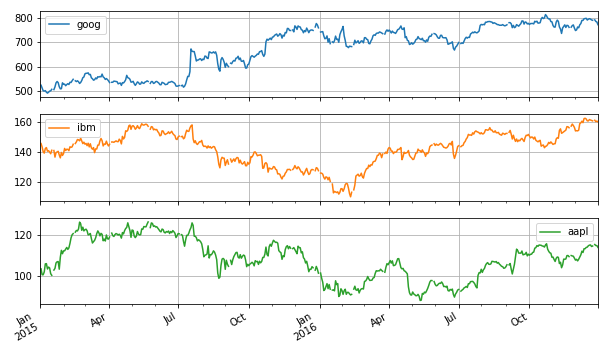

In [3]:
dates=pd.date_range('2015-01-01','2016-12-31',freq='B')#每个工作日记录
symbols=['goog','ibm','aapl']
df = stocks_data(symbols,dates)

df.fillna(method='ffill')#nan填充
df.plot(figsize=(10,6),grid=True,subplots=True)

#### 构造实验数据集

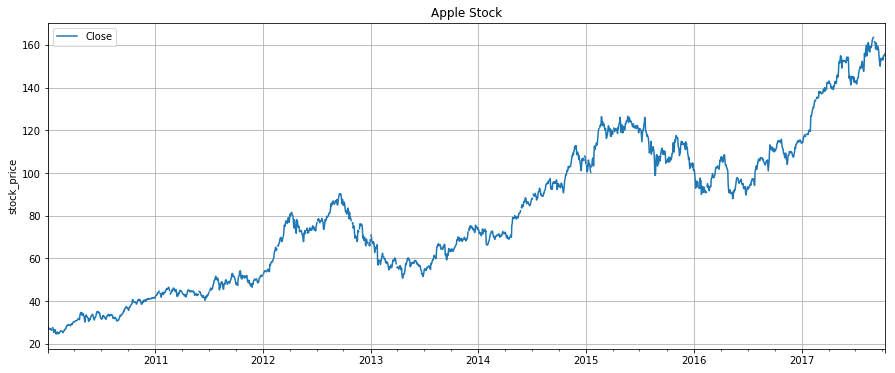

In [4]:
dates=pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_appl=pd.read_csv("D:/Code/Ipynb/Pytorch/Homework/data/Stock/aapl.us.txt",
                            index_col=0,
                            parse_dates=True)
df_appl=df1.join(df_appl)
df_appl[['Close']].plot(figsize=(15,6))
plt.ylabel("stock_price")
plt.title("Apple Stock")
plt.grid()
plt.show()

##### 查看原始数据

In [5]:
df_appl
print("{:=^50s}".format("查看df_appl的前面五条数据"))
print(df_appl.head())
print("{:=^50s}".format("查看df_appl的简要信息"))
print(df_appl.info())

=================查看df_appl的前面五条数据=================
              Open    High     Low   Close       Volume  OpenInt
2010-01-04  27.341  27.470  27.199  27.406  137045797.0      0.0
2010-01-05  27.508  27.609  27.310  27.454  167718021.0      0.0
2010-01-06  27.454  27.563  26.990  27.017  153403690.0      0.0
2010-01-07  27.108  27.148  26.772  26.968  132861904.0      0.0
2010-01-08  26.946  27.148  26.774  27.147  124730848.0      0.0
==================查看df_appl的简要信息==================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1958 non-null   float64
 1   High     1958 non-null   float64
 2   Low      1958 non-null   float64
 3   Close    1958 non-null   float64
 4   Volume   1958 non-null   float64
 5   OpenInt  1958 non-null   float64
dtypes: float64(6)
memory usage: 190.9 KB
None


In [6]:
df_appl=df_appl[['Close']] #选取Close列
print("{:=^50s}".format("查看df_appl的前面五条数据"))
print(df_appl.head())
print("{:=^50s}".format("查看df_appl的简要信息"))
print(df_appl.info())

=================查看df_appl的前面五条数据=================
             Close
2010-01-04  27.406
2010-01-05  27.454
2010-01-06  27.017
2010-01-07  26.968
2010-01-08  27.147
==================查看df_appl的简要信息==================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 111.7 KB
None


In [7]:
#填充空值
df_appl=df_appl.fillna(method='ffill')
print("{:=^50s}".format("查看df_appl的前面五条数据"))
print(df_appl.head())
print("{:=^50s}".format("查看df_appl的简要信息"))
print(df_appl.info())

=================查看df_appl的前面五条数据=================
             Close
2010-01-04  27.406
2010-01-05  27.454
2010-01-06  27.017
2010-01-07  26.968
2010-01-08  27.147
==================查看df_appl的简要信息==================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2028 non-null   float64
dtypes: float64(1)
memory usage: 111.7 KB
None


In [8]:
#对数据进行归一化
scaler=MinMaxScaler(feature_range=(-1,1))
df_appl['Close']=scaler.fit_transform(df_appl['Close'].values.reshape(-1,1))
df_appl.head()

,Close
2010-01-04,-0.959501
2010-01-05,-0.958809
2010-01-06,-0.965103
2010-01-07,-0.965809
2010-01-08,-0.963231


#### 训练集、测试集划分

In [9]:
def load_data(stock,look_back):
    data_raw = stock.values #numpy array类型
    data = []
    for index in range(len(data_raw)-look_back):
        #从data_raw中截取长度为look_back的数据
        data.append(data_raw[index:index+look_back]) #使用list拼接数据集
    data = np.array(data) #shape:(1968,60,1) #再转化为numpy array类型
    #Close列一共有1968行，每隔60个数据点取一个样本，前59个数据点作为输入后一个作为输出
    
    test_set_size=int(np.round(0.2*data.shape[0])) #测试集占data的20%
    train_set_size=data.shape[0]-(test_set_size)
    
    x_train=torch.Tensor(data[:train_set_size,:-1,:]) #转化为张量
    y_train=torch.Tensor(data[:train_set_size,-1,:])
    x_test=torch.Tensor(data[train_set_size:,:-1,:])
    y_test=torch.Tensor(data[train_set_size:,-1,:])
    return [x_train,y_train,x_test,y_test]

In [10]:
x_train,y_train,x_test,y_test=load_data(df_appl,look_back=60)

#### 定义LSTM模型

In [11]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_dim=output_dim
        
        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,(hn,cn)=self.lstm(x,(h0.detach(),c0.detach()))
        #(hn,cn)：隐藏状态，hidden state 和 cell state
        out=self.fc(out[:,-1,:])
        return out

In [12]:
class RNN(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(RNN,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_dim=output_dim
        
        self.rnn=nn.RNN(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,hn=self.rnn(x,h0.detach())
        #hn：隐藏状态，hidden state 
        out=self.fc(out[:,-1,:])
        return out

In [13]:
class GRU(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(GRU,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_dim=output_dim
        
        self.gru=nn.GRU(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,hn=self.gru(x,h0.detach())
        #hn：隐藏状态，hidden state 
        out=self.fc(out[:,-1,:])
        return out

In [14]:
loss_fn = nn.MSELoss()
lstm_model=LSTM(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1)
rnn_model=RNN(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1)
gru_model=GRU(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),lr=0.01)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(),lr=0.01)
gru_optimizer = torch.optim.Adam(gru_model.parameters(),lr=0.01)

#### 训练模型

In [15]:
num_epochs=200
lstm_hist=np.zeros(num_epochs)
print("LSTM's training:")
for t in range(num_epochs):
    lstm_y_train_pred=lstm_model(x_train)
    loss=loss_fn(lstm_y_train_pred,y_train)
    if t%10==0 and t!=0:
        print("Epoch:",t,"MSE:{}".format(loss.item()))
    lstm_hist[t]=loss.item()
    lstm_optimizer.zero_grad()
    loss.backward()
    lstm_optimizer.step()

LSTM's training:
Epoch: 10 MSE:0.05990975722670555
Epoch: 20 MSE:0.009693899191915989
Epoch: 30 MSE:0.005032362416386604
Epoch: 40 MSE:0.002393912523984909
Epoch: 50 MSE:0.0014869768638163805
Epoch: 60 MSE:0.0011672646505758166
Epoch: 70 MSE:0.0008976282551884651
Epoch: 80 MSE:0.0008605027687735856
Epoch: 90 MSE:0.0008397363126277924
Epoch: 100 MSE:0.0008119785343296826
Epoch: 110 MSE:0.0007923510274849832
Epoch: 120 MSE:0.0007766466005705297
Epoch: 130 MSE:0.0007619993994012475
Epoch: 140 MSE:0.0007479958585463464
Epoch: 150 MSE:0.0007346179336309433
Epoch: 160 MSE:0.0007217794773168862
Epoch: 170 MSE:0.000709407206159085
Epoch: 180 MSE:0.0006974590942263603
Epoch: 190 MSE:0.0006859045242890716


In [16]:
num_epochs=200
rnn_hist=np.zeros(num_epochs)
print("RNN's training:")
for t in range(num_epochs):
    rnn_y_train_pred=rnn_model(x_train)
    loss=loss_fn(rnn_y_train_pred,y_train)
    if t%10==0 and t!=0:
        print("Epoch:",t,"MSE:{}".format(loss.item()))
    rnn_hist[t]=loss.item()
    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()

RNN's training:
Epoch: 10 MSE:0.016355402767658234
Epoch: 20 MSE:0.004196456633508205
Epoch: 30 MSE:0.0016968511044979095
Epoch: 40 MSE:0.001396673615090549
Epoch: 50 MSE:0.0007700706482864916
Epoch: 60 MSE:0.0005308116087689996
Epoch: 70 MSE:0.0004925454268231988
Epoch: 80 MSE:0.0004527943965513259
Epoch: 90 MSE:0.00043474245467223227
Epoch: 100 MSE:0.00041993462946265936
Epoch: 110 MSE:0.00040909828385338187
Epoch: 120 MSE:0.00040030619129538536
Epoch: 130 MSE:0.0003928240039385855
Epoch: 140 MSE:0.0003865156031679362
Epoch: 150 MSE:0.0003811094502452761
Epoch: 160 MSE:0.0003764340071938932
Epoch: 170 MSE:0.00037236427306197584
Epoch: 180 MSE:0.00036879873368889093
Epoch: 190 MSE:0.00036565487971529365


In [17]:
num_epochs=200
gru_hist=np.zeros(num_epochs)
print("GRU's training:")
for t in range(num_epochs):
    gru_y_train_pred=gru_model(x_train)
    loss=loss_fn(gru_y_train_pred,y_train)
    if t%10==0 and t!=0:
        print("Epoch:",t,"MSE:{}".format(loss.item()))
    gru_hist[t]=loss.item()
    gru_optimizer.zero_grad()
    loss.backward()
    gru_optimizer.step()

GRU's training:
Epoch: 10 MSE:0.016432832926511765
Epoch: 20 MSE:0.002062698593363166
Epoch: 30 MSE:0.0016393556725233793
Epoch: 40 MSE:0.0012723477557301521
Epoch: 50 MSE:0.0005011701141484082
Epoch: 60 MSE:0.0004432112327776849
Epoch: 70 MSE:0.00042394769843667746
Epoch: 80 MSE:0.00038330440293066204
Epoch: 90 MSE:0.00037818338023498654
Epoch: 100 MSE:0.0003694583720061928
Epoch: 110 MSE:0.00036449209437705576
Epoch: 120 MSE:0.00035974764614365995
Epoch: 130 MSE:0.0003561173507478088
Epoch: 140 MSE:0.00035286814090795815
Epoch: 150 MSE:0.00035002699587494135
Epoch: 160 MSE:0.00034752566716633737
Epoch: 170 MSE:0.000345289969118312
Epoch: 180 MSE:0.00034328154288232327
Epoch: 190 MSE:0.0003414664533920586


##### 绘制损失函数图像

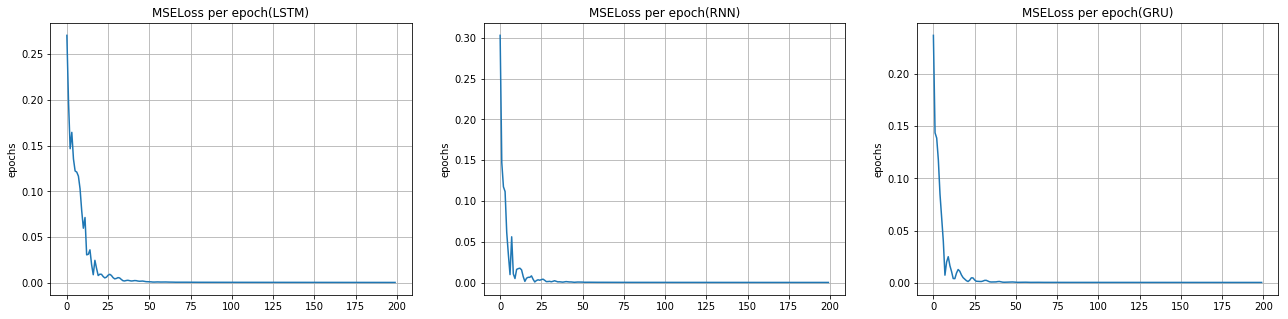

In [18]:
plt.figure(figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(range(num_epochs),lstm_hist[range(num_epochs)])
plt.ylabel("epochs")
plt.title("MSELoss per epoch(LSTM)")
plt.grid()

plt.subplot(1,3,2)
plt.plot(range(num_epochs),rnn_hist[range(num_epochs)])
plt.ylabel("epochs")
plt.title("MSELoss per epoch(RNN)")
plt.grid()

plt.subplot(1,3,3)
plt.plot(range(num_epochs),gru_hist[range(num_epochs)])
plt.ylabel("epochs")
plt.title("MSELoss per epoch(GRU)")
plt.grid()

plt.show()

#### 查看股票预测结果

In [19]:
# 对数据进行反归一化，同时转化为 numpy 的数据格式
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

lstm_y_test_pred = lstm_model(x_test) # 对测试数据执行预测
lstm_y_train_pred = scaler.inverse_transform(lstm_y_train_pred.detach().numpy())
lstm_y_test_pred = scaler.inverse_transform(lstm_y_test_pred.detach().numpy())

rnn_y_test_pred = rnn_model(x_test) # 对测试数据执行预测
rnn_y_train_pred = scaler.inverse_transform(rnn_y_train_pred.detach().numpy())
rnn_y_test_pred = scaler.inverse_transform(rnn_y_test_pred.detach().numpy())

gru_y_test_pred = gru_model(x_test) # 对测试数据执行预测
gru_y_train_pred = scaler.inverse_transform(gru_y_train_pred.detach().numpy())
gru_y_test_pred = scaler.inverse_transform(gru_y_test_pred.detach().numpy())

##### 预测结果可视化

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


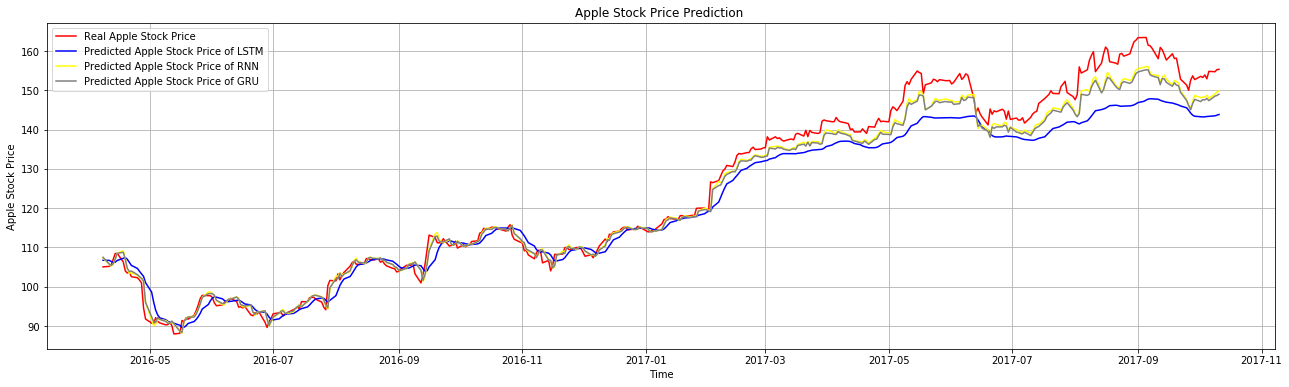

In [20]:
figure,axes = plt.subplots(figsize=(22,6))
axes.xaxis_date()
axes.plot(df_appl[len(df_appl)-len(y_test):].index, y_test, color = 'red',
          label = 'Real Apple Stock Price')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, lstm_y_test_pred, color = 'blue',
          label = 'Predicted Apple Stock Price of LSTM')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, rnn_y_test_pred, color = 'yellow',
          label = 'Predicted Apple Stock Price of RNN')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, gru_y_test_pred, color = 'grey',
          label = 'Predicted Apple Stock Price of GRU')
plt.title('Apple Stock Price Prediction ')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


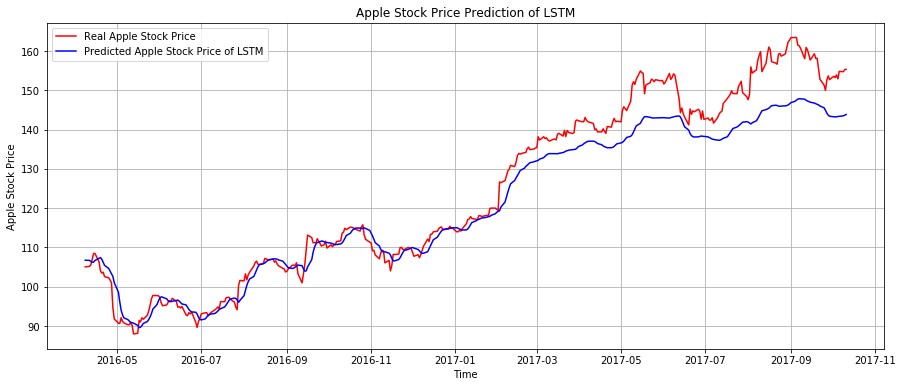

In [21]:
figure,axes = plt.subplots(figsize=(15,6))
axes.xaxis_date()
axes.plot(df_appl[len(df_appl)-len(y_test):].index, y_test, color = 'red',
          label = 'Real Apple Stock Price')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, lstm_y_test_pred, color = 'blue',
          label = 'Predicted Apple Stock Price of LSTM')
plt.title('Apple Stock Price Prediction of LSTM')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


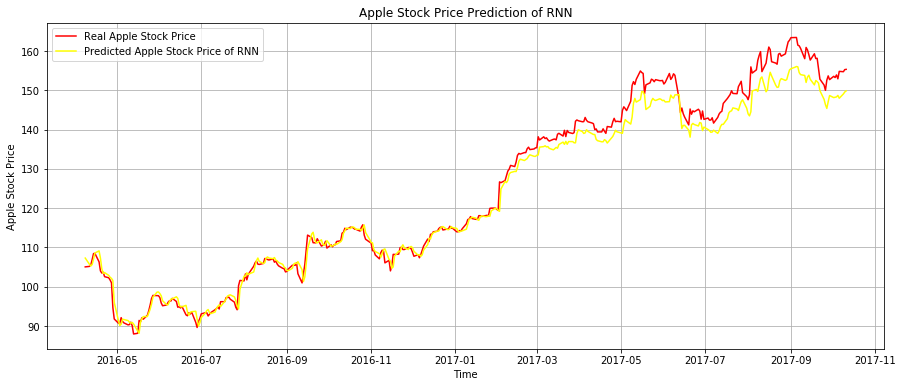

In [22]:
figure,axes = plt.subplots(figsize=(15,6))
axes.xaxis_date()
axes.plot(df_appl[len(df_appl)-len(y_test):].index, y_test, color = 'red',
          label = 'Real Apple Stock Price')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, rnn_y_test_pred, color = 'yellow',
          label = 'Predicted Apple Stock Price of RNN')
plt.title('Apple Stock Price Prediction of RNN')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


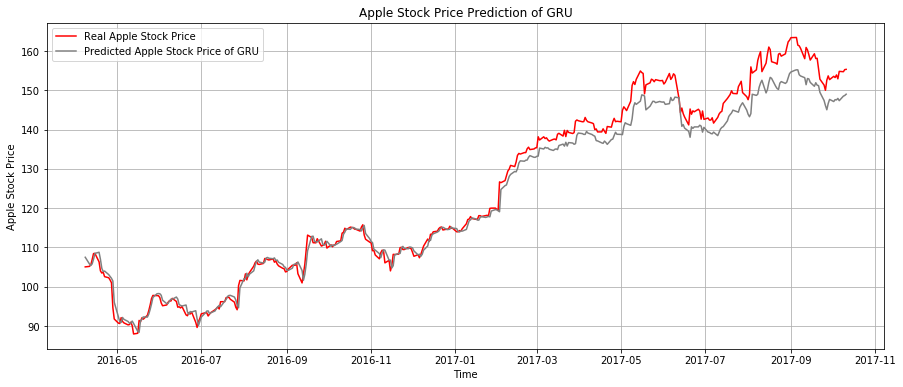

In [23]:
figure,axes = plt.subplots(figsize=(15,6))
axes.xaxis_date()
axes.plot(df_appl[len(df_appl)-len(y_test):].index, y_test, color = 'red',
          label = 'Real Apple Stock Price')
axes.plot(df_appl[len(df_appl)-len(y_test):].index, gru_y_test_pred, color = 'grey',
          label = 'Predicted Apple Stock Price of GRU')
plt.title('Apple Stock Price Prediction of GRU')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.grid()
plt.show()